In [225]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

import yfinance as yf
from ta_utils import *
from pprint import *

In [244]:
start_date = "2010-10-11"
end_date = "2023-11-19"
interval = '1d'

stock1 = "HALKB.IS"
stock2 = "VAKBN.IS"

In [245]:
s1 = yf.download(stock1, start=start_date, end=end_date, interval=interval)
s2 = yf.download(stock2, start=start_date, end=end_date, interval=interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [246]:
#s1['Adj Close']=np.log(s1['Close']/s1['Open'])
#s2['Adj Close']=np.log(s2['Close']/s2['Open'])

## Spreading

In [247]:
#Regression Model
y = np.log(s1['Adj Close'])
x = np.log(s2['Adj Close'])

#y = s1['Adj Close']
#x = s2['Adj Close']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.params

const        1.618289
Adj Close    0.363510
dtype: float64

In [248]:
# Get Spread
alpha = results.params.values[0]
beta = results.params.values[1]
errors = y-(alpha + x['Adj Close']*beta)

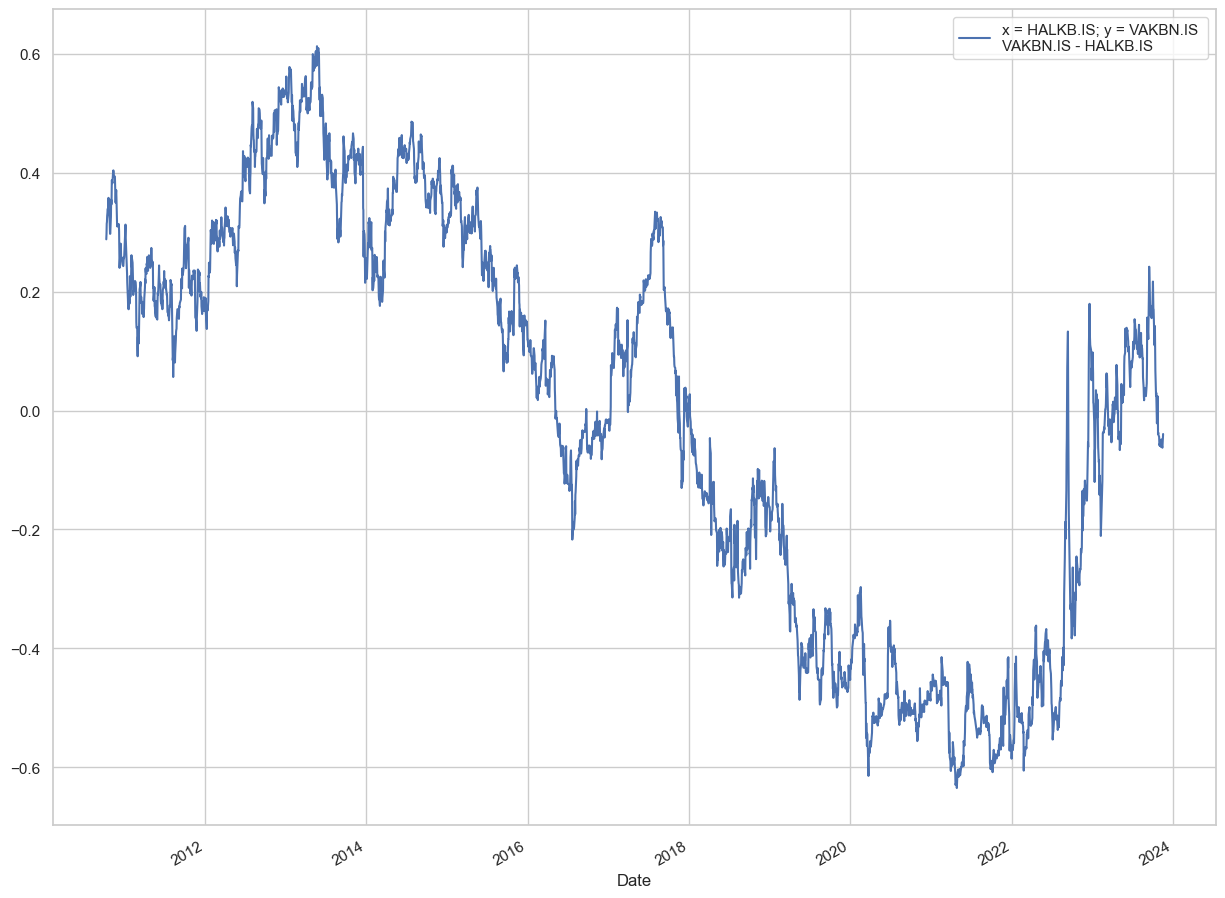

In [249]:
# Charting Spread
errors.plot(label =f"x = {stock1}; y = {stock2} \n{stock2} - {stock1}",figsize=(15,12))
plt.legend()

## Dickey Fuller Test

In [250]:
dftest = adfuller(errors,maxlag=1)
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic","p-value","#Lags Used","#Observations"]
)
critical_values = pd.Series(dftest[4].values(),index=dftest[4].keys())

print("Dickey Fuller Results")
pprint(dfoutput)
print("\n")
print("Dickey Fuller Critical Values")
pprint(critical_values)

Dickey Fuller Results
Test Statistic      -1.750788
p-value              0.405153
#Lags Used           1.000000
#Observations     3376.000000
dtype: float64


Dickey Fuller Critical Values
1%    -3.432288
5%    -2.862397
10%   -2.567226
dtype: float64


## Z-Score

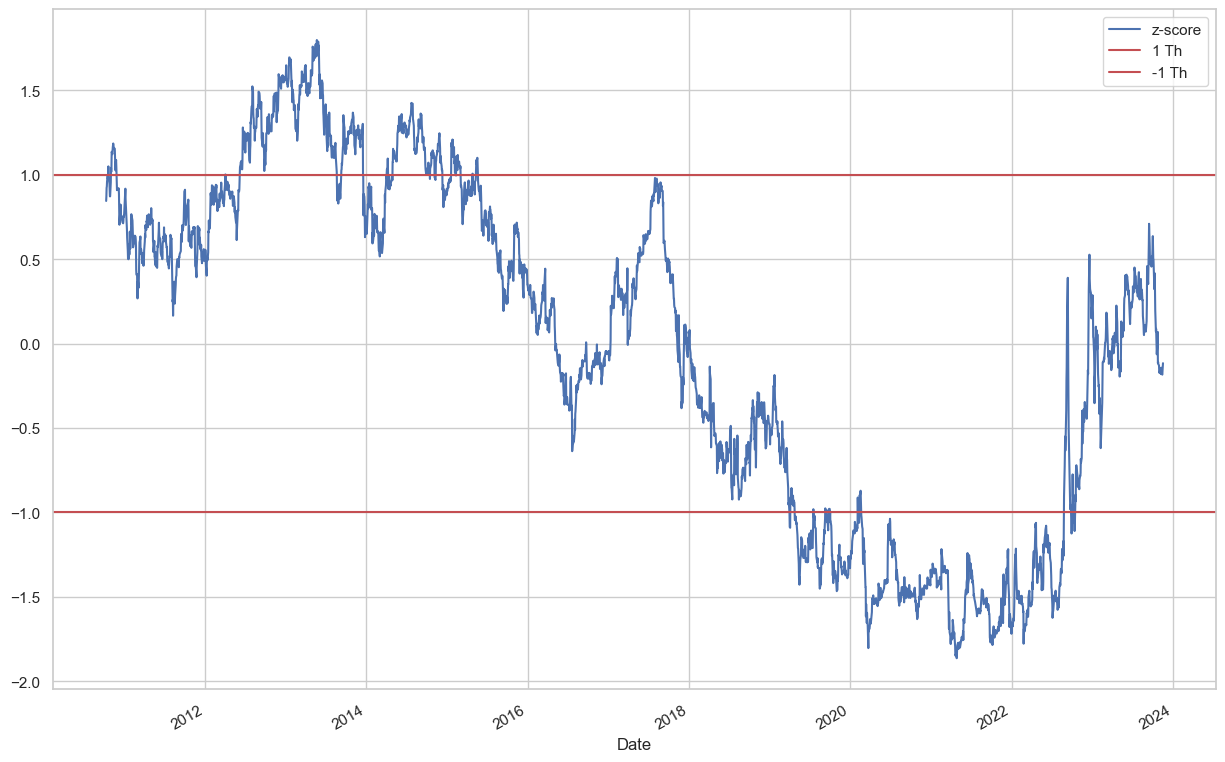

In [251]:
spread = errors 
zscore = (spread - np.mean(spread))/np.std(spread)
zscore.plot(label="z-score",figsize=(15,10))

plt.axhline(y=1,color='r',label='1 Th')
plt.axhline(y=-1,color='r',label='-1 Th')

plt.legend()

## Backtesting 

In [252]:
signal_entry = 1
signal_exit=0

btest = pd.DataFrame()
btest['stock2']=s2['Close']
btest['stock1']=s1['Close']
btest['shortSignal']=(zscore>signal_entry) & (zscore.shift(1)<signal_entry)
btest['shortExit']=(zscore<signal_exit) & (zscore.shift(1)>signal_exit)

btest['longSignal'] = (zscore < -signal_entry) & (zscore.shift(1)> -signal_entry)
btest['longExit'] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

In [253]:
spread_side = None
counter = -1
backtest_result = []
indicator = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    # Check if the counter has reached the end of the DataFrame
    if counter >= len(btest):
        break

    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock
    
    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])
        if short_signal:
            spread_side = "short"
        elif long_signal:
            spread_side = "long"
            
    elif spread_side == "long":
        return_stock2 = btest['stock2'][counter] / btest['stock2'][counter-1] - 1
        return_stock1 = btest['stock1'][counter] / btest['stock1'][counter-1] - 1
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])
        
        if long_exit:
            spread_side = None
                
    elif spread_side == "short":
        return_stock2 = btest['stock2'][counter] / btest['stock2'][counter-1] - 1
        return_stock1 = btest['stock1'][counter] / btest['stock1'][counter-1] - 1
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])
        
        if short_exit:
            spread_side = None


In [254]:
bt = pd.DataFrame(backtest_result)
bt.columns = ['Date','stock2','stock1','side']
bt['stock2_pl']=np.cumprod(bt['stock2']+1)
bt['stock1_pl']=np.cumprod(bt['stock1']+1)
bt['total_pl']=(bt['stock1_pl']+bt['stock2_pl'])/2
bt.index=bt['Date']

In [255]:
bt

,Date,stock2,stock1,side,stock2_pl,stock1_pl,total_pl
Date,,,,,,,
2010-10-11,2010-10-11,0.0,0.0,None,1.000000,1.000000,1.000000
2010-10-12,2010-10-12,0.0,0.0,None,1.000000,1.000000,1.000000
2010-10-13,2010-10-13,0.0,0.0,None,1.000000,1.000000,1.000000
2010-10-14,2010-10-14,0.0,0.0,None,1.000000,1.000000,1.000000
2010-10-15,2010-10-15,0.0,0.0,None,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...
2023-11-13,2023-11-13,0.0,0.0,None,2.052724,0.092021,1.072373
2023-11-14,2023-11-14,0.0,0.0,None,2.052724,0.092021,1.072373
2023-11-15,2023-11-15,0.0,0.0,None,2.052724,0.092021,1.072373


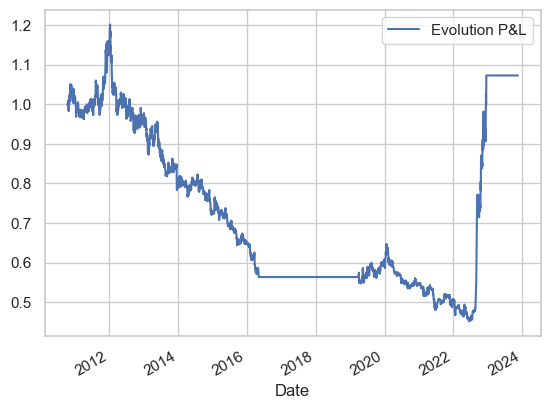

In [256]:
# Ploting
bt['total_pl'].plot(label="Evolution P&L")
plt.legend()